# #6 Two-level recommendation models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

print('Done')

Done


In [3]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../raw_data/product.csv')
user_features = pd.read_csv('../raw_data/hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3

data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)] # давние покупки
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

In [ ]:
user_features.shape, item_features.shape

((801, 8), (92353, 7))

In [ ]:
print('data_train_lvl_1: {}-{} weeks'.format(data_train_lvl_1.week_no.min(), data_train_lvl_1.week_no.max()))
print('data_val_lvl_1: {}-{} weeks'.format(data_val_lvl_1.week_no.min(), data_val_lvl_1.week_no.max()))

print('data_train_lvl_2: {}-{} weeks'.format(data_train_lvl_2.week_no.min(), data_train_lvl_2.week_no.max()))
print('data_val_lvl_2: {}-{} weeks'.format(data_val_lvl_2.week_no.min(), data_val_lvl_2.week_no.max()))

data_train_lvl_1: 1-85 weeks
data_val_lvl_1: 86-91 weeks
data_train_lvl_2: 86-91 weeks
data_val_lvl_2: 92-95 weeks


In [4]:
data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features, 5000)

== Starting prefilter info ==
shape: (2108779, 12)
# users: 2498
# items: 83685
Sparsity: 1.009%
== Ending prefilter info ==
shape: (1561869, 13)
# users: 2482
# items: 5000
Sparsity: 12.586%


In [5]:
recommender = MainRecommender(data_train_lvl_1)

100%|██████████| 5000/5000 [00:00<00:00, 7909.57it/s]


### **`Testing different values of @N`**

In [ ]:
rk_result = {}
train_users = data_train_lvl_1['user_id'].unique()

item_ids_by_users = data_val_lvl_1.groupby('user_id').item_id.unique().reset_index()
item_ids_by_users.columns = ['user_id', 'actual']
users_lvl_1 = pd.DataFrame(data_val_lvl_1['user_id'].unique())
users_lvl_1.columns = ['user_id']
users_lvl_1 = users_lvl_1[users_lvl_1.user_id.isin(train_users)]


for k in (20, 50, 100, 200, 500):
    users_lvl_1['candidates'] = users_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, k))
    m = np.mean([recall_at_k(a, p) for a,p in zip(item_ids_by_users['actual'].tolist(), users_lvl_1['candidates'].tolist())])
    rk_result[k] = m


rk_result

{20: 0.0010339661566421887,
 50: 0.0017560665771922854,
 100: 0.0019892957395472705,
 200: 0.0024629906901334386,
 500: 0.0023835662358580928}

In [8]:
mark_df = pd.DataFrame.from_dict(rk_result, orient='index').reset_index()
mark_df.columns = ['k', 'mean_average_recall']
mark_df

,k,mean_average_recall
0,20,0.001034
1,50,0.001756
2,100,0.001989
3,200,0.002463
4,500,0.002384


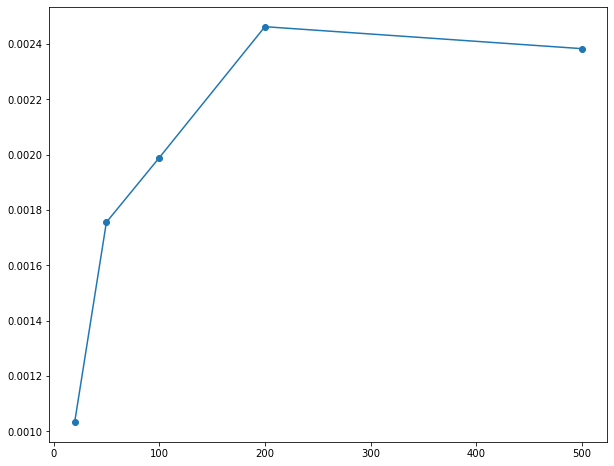

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(mark_df.k, mark_df.mean_average_recall, marker='o')

plt.show()

### **`Testing various number of weeks for validation datasample`**

In [10]:
data_split_size_to_recall = {}
for size_weeks in range(1, 12):
    data_val_lvl1 = data[(data['week_no'] >= data['week_no'].max() - (size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]
    
    users = pd.DataFrame(data_val_lvl1['user_id'].unique())
    users.columns = ['user_id']

    users = users[users.user_id.isin(train_users)]

    item_ids_by_users = data_val_lvl1.groupby('user_id').item_id.unique().reset_index()
    item_ids_by_users.columns = ['user_id', 'actual']

    users['candidates'] = users['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    m = np.mean([recall_at_k(a, p) for a,p in zip(item_ids_by_users['actual'].tolist(), users['candidates'].tolist())])
    data_split_size_to_recall[size_weeks] = m

data_split_size_to_recall

{1: 0.0011654556302480123,
 2: 0.0014292209235736977,
 3: 0.001495902692337063,
 4: 0.001577515108396672,
 5: 0.0013590916715392081,
 6: 0.0017560665771922854,
 7: 0.001600243550731298,
 8: 0.0018135687676887583,
 9: 0.0015296008536488607,
 10: 0.0018071378066584905,
 11: 0.0017504041589370546}

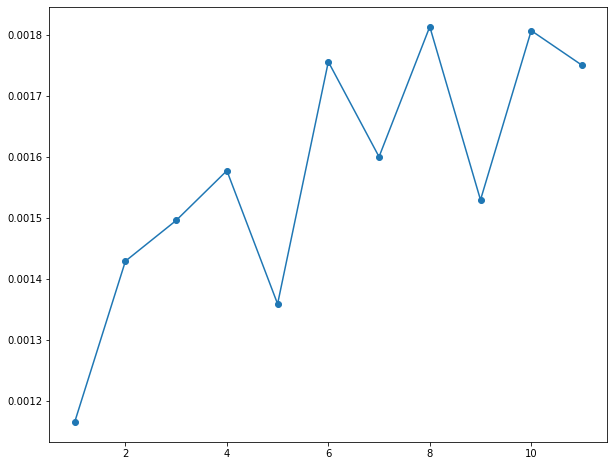

In [11]:
mark_df = pd.DataFrame.from_dict(data_split_size_to_recall, orient='index').reset_index()
mark_df.columns = ['weeks_num', 'mean_average_recall']

plt.figure(figsize=(10, 8))
plt.plot(mark_df.weeks_num, mark_df.mean_average_recall, marker='o')

plt.show()

### **`Prepare validation users (warm start without new customers)`**

In [34]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=500))

### **`Create new user features`**

`- purchase frequency by one month`

`- purchases number on each of the department`

In [18]:
# User new feature:
#   "purchase frequency by one month"
def merge_purchase_freq_by_month(user_features, data):
    data = data[data.user_id.isin(user_features.user_id.unique().tolist())]
    data_quantity = data.groupby(['user_id']).quantity.sum().reset_index()
    data_months=data.groupby('user_id').apply(lambda x: ((x.week_no.max() - x.week_no.min())//4)).reset_index().rename(columns={0: 'n_months'})
    
    data = data_quantity.merge(data_months, on='user_id')
    data.loc[data.n_months < 1] = 1
    data['quantity_per_month'] = data.quantity / data.n_months
    user_features = user_features.merge(data[['user_id', 'quantity_per_month']], on='user_id', how='right')
    user_features['quantity_per_month'] = user_features.quantity_per_month.astype('int64')
    return user_features

# make pivot from department and user_id 
# >> purchases number of each department
def merge_pivot_by_departments(user_features, data):
    dt_tmp = user_features[['user_id']].merge(
        data.groupby(['user_id', 'item_id']).sales_value.sum().reset_index(), on='user_id').merge(
            item_features[['item_id', 'department']], on='item_id'
        ).groupby(['user_id', 'department']).sales_value.mean().reset_index()
    
    dep_pivot = pd.pivot_table(
            dt_tmp, 
            index='user_id', columns=['department'], 
            values='sales_value',
            # aggfunc='count', 
            fill_value=0
        ).reset_index() 
    user_features = user_features.merge(dep_pivot, on='user_id', how='left')

    return user_features

### **`Create pairwise features (user_id-item_id)`**

`- price item_id`

`- mean price by department`

In [19]:
# User-Item new features:
#     "price",
#     "mean price by department"

def merge_ratio_mean_price_by_department(item_features, data):
    data = data[data.item_id.isin(item_features.item_id.unique().tolist())]
    
    s = item_features[['item_id', 'department']].merge(data[['item_id', 'sales_value', 'quantity']], on='item_id', how='right')
    s['price'] = s.sales_value / np.maximum(s.quantity, 1)
    s_mean = s.groupby('department').price.mean().reset_index()
    s_mean.columns = ['department', 'mean_price_by_department']
    
    item_features = item_features.merge(s_mean, on='department', how='left')
    item_features = item_features.join(s['price'])

    return item_features

### **`Create new item features`**

`- department pivot table`

`- number of items selling per one week`

In [20]:
# item new features:
# quantity selling per week

def merge_quantity_selling_per_week(item_features, data):
    d = data.copy()
    d = d[d.item_id.isin(item_features.item_id.unique().tolist())]
    d_sales = d.groupby('item_id').sales_value.sum().reset_index()
    d_weeks = d.groupby('item_id').apply(
        lambda x: x.week_no.max() - x.week_no.min()
        ).reset_index().rename(columns={0:'n_weeks'})
    d_weeks.loc[d_weeks.n_weeks == 0] = 1
    d_sales_weeks = d_weeks.merge(d_sales, on='item_id')
    d_sales_weeks['sales_by_week'] = d_sales_weeks.sales_value / d_sales_weeks.n_weeks
   
    item_features = item_features.merge(d_sales_weeks[['item_id', 'sales_by_week']], on='item_id', how='left')
    return item_features.fillna(0)
 
#   "ratio of price to average price of the department"
# + "ratio of mean prices by department"
def merge_price_rel_by_department(item_features, data):
    item_features = merge_ratio_mean_price_by_department(item_features, data)
    item_features['price_rel_mean_by_department'] = item_features.price / item_features.mean_price_by_department        
    
    return item_features

In [9]:
print('user_features start shape:', user_features.shape)
user_features = merge_purchase_freq_by_month(user_features, data_train_lvl_2)
user_features = merge_pivot_by_departments(user_features, data_train_lvl_2)
print('user_features end shape: {}\n'.format(user_features.shape))

print('item_features start shape: {}'.format(item_features.shape))
item_features = merge_quantity_selling_per_week(item_features, data_train_lvl_2)
item_features = merge_price_rel_by_department(item_features, data_train_lvl_2)
print('item_features end shape: {}'.format(item_features.shape))


user_features start shape: (801, 8)
user_features end shape: (791, 37)

item_features start shape: (92353, 7)
item_features end shape: (92353, 11)


In [28]:
pd.set_option('max_columns', None)
user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,quantity_per_month,,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DELI,DRUG GM,FLORAL,FROZEN GROCERY,GARDEN CENTER,GM MERCH EXP,GROCERY,KIOSK-GAS,MEAT,MEAT-PCKGD,MISC SALES TRAN,MISC. TRANS.,NUTRITION,PASTRY,PHOTO,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TRAVEL & LEISUR
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,148,0,0.0,0,0.0,0.0,2.4375,4.897273,0.00,0.0,0.0,0.0,2.944737,0.00,0.000,4.652500,0.00,0.0,2.69,2.33,0.0,1.867500,0.0,0.0,11.13,0.0,0.00,0.0,0.0
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7,116,0,0.0,0,0.0,0.0,5.9900,2.985000,0.00,0.0,0.0,0.0,1.958955,0.00,5.500,2.693333,0.00,0.0,2.00,0.89,0.0,2.671667,0.0,0.0,0.00,0.0,0.00,0.0,0.0
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8,143,0,0.0,0,0.0,0.0,0.0000,1.513333,12.99,0.0,0.0,0.0,2.444884,0.00,4.335,4.992500,0.00,0.0,0.00,2.99,0.0,2.070000,0.0,0.0,1.68,0.0,4.99,0.0,0.0
3,25-34,U,75-99K,Homeowner,2 Adults Kids,4,2,13,152849,0,0.0,0,0.0,0.0,2.8300,9.958235,0.00,0.0,0.0,0.0,4.201290,166.02,0.000,3.495000,183.39,0.0,0.00,0.00,0.0,2.910000,0.0,0.0,0.00,0.0,0.00,0.0,0.0
4,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,1,0,0.0,0,0.0,0.0,2.4375,4.897273,0.00,0.0,0.0,0.0,2.944737,0.00,0.000,4.652500,0.00,0.0,2.69,2.33,0.0,1.867500,0.0,0.0,11.13,0.0,0.00,0.0,0.0


In [29]:
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,sales_by_week,mean_price_by_department,price,price_rel_mean_by_department
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,0.0,2.098295,1.00,0.476577
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0.0,2.569208,0.99,0.385333
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,0.0,3.112660,1.77,0.568646
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,0.0,2.098295,1.67,0.795884
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,0.0,2.098295,2.50,1.191443


In [35]:
s = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'

users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(s)
users_lvl_2['flag'] = 1

targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)
targets_lvl_2.drop('flag', axis=1, inplace=True)

targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

In [37]:
targets_lvl_2.sample(5)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,sales_by_week,mean_price_by_department,price,price_rel_mean_by_department,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,quantity_per_month,,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DELI,DRUG GM,FLORAL,FROZEN GROCERY,GARDEN CENTER,GM MERCH EXP,GROCERY,KIOSK-GAS,MEAT,MEAT-PCKGD,MISC SALES TRAN,MISC. TRANS.,NUTRITION,PASTRY,PHOTO,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TRAVEL & LEISUR
249820,589,849843,0.0,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,MAINSTREAM WHEAT/MULTIGRAIN BR,20 OZ,87.010,2.098295,5.29,2.521094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
227039,1314,1062660,0.0,181,GROCERY,National,DRY BN/VEG/POTATO/RICE,RICE SIDE DISH MIXES DRY,,2.400,2.098295,3.50,1.668021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
735473,2367,1133018,0.0,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,,165.520,2.098295,0.99,0.471812,45-54,U,Under 15K,Unknown,2 Adults No Kids,2,None/Unknown,45.0,0.0,0.0,0.0,0.0,0.0,2.11,4.105714,0.0,0.0,0.0,0.0,1.590556,0.0,2.49,1.913333,0.0,0.0,0.0,0.0,0.0,1.885,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1006125,112,904360,0.0,673,PRODUCE,National,VEGETABLES SALAD,HEAD LETTUCE,24CT,4.950,2.075660,0.20,0.096355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1095084,203,1075470,0.0,2150,GROCERY,National,BAG SNACKS,POTATO CHIPS,8 OZ,22.226,2.098295,1.89,0.900731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# new users need to be added to user_features...
user_features[user_features.user_id == 112]

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,quantity_per_month,,CHEF SHOPPE,CNTRL/STORE SUP,COSMETICS,COUP/STR & MFG,DELI,DRUG GM,FLORAL,FROZEN GROCERY,GARDEN CENTER,GM MERCH EXP,GROCERY,KIOSK-GAS,MEAT,MEAT-PCKGD,MISC SALES TRAN,MISC. TRANS.,NUTRITION,PASTRY,PHOTO,PRODUCE,RESTAURANT,RX,SALAD BAR,SEAFOOD,SEAFOOD-PCKGD,SPIRITS,TRAVEL & LEISUR


In [58]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]
X_train.shape, y_train.shape

((1157237, 48), (1157237, 1))

In [59]:
cat_feats = ['manufacturer', 'department', 'brand',
    'commodity_desc', 'sub_commodity_desc', 'curr_size_of_product',
    'age_desc', 'marital_status_code',
    'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc',
    'kid_category_desc']

X_train[cat_feats] = X_train[cat_feats].astype('category')

In [60]:
lgb = LGBMClassifier(objective='binary', max_depth=7, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

train_preds = lgb.predict(X_train)

/home/alina/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/alina/anaconda3/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


In [73]:
recall_at_k(train_preds, y_train.target)

0.5